# CMS Data Exploration

Here we are examining the data from Centers for Medicare and Medicaid Services for 2019's general open payments system. Open payments reveal the nature of payments from companies to doctors and hospitals for the sake of transparency between healthcare professionals, drug companies, and the public. From the CMS website's summary information, we see that 1602 companies made 10.3 million general payments totalling 3.56 billion USD to 1196 teaching hospitals and 615k physicians.

Our query is how can a drug company optimize its spending? What inputs (physician name, type, hospital) determine the cost of a particular transaction? We will explore what the data contains and what it does not contain?

Additionally, once we have some insight regarding spending patterns of various companies, we might be able to use machine learning techniques to build a recommendation system: how can a company build a budget for a future year? Based on hospital / physician, is there a recommended expenditure?

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime

## Loading Data

In [2]:
# Not specifying "Dtype"-argument yields: DtypeWarning:
# Columns 4,7,9,11,14,16,17,21,22,23,24,28,35,36,37,40,41,42,43,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72
# have mixed types.Specify dtype option on import or set low_memory=False.
cms_gen_data = pd.read_csv('D:/Documents/Projects/Data_Sets/PGYR19_P063020/OP_DTL_GNRL_PGYR2019_P06302020.csv', low_memory=False)

In [3]:
cms_gen_data.head()

,Change_Type,Covered_Recipient_Type,Teaching_Hospital_CCN,Teaching_Hospital_ID,Teaching_Hospital_Name,Physician_Profile_ID,Physician_First_Name,Physician_Middle_Name,Physician_Last_Name,Physician_Name_Suffix,...,Product_Category_or_Therapeutic_Area_4,Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_4,Associated_Drug_or_Biological_NDC_4,Covered_or_Noncovered_Indicator_5,Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_5,Product_Category_or_Therapeutic_Area_5,Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_5,Associated_Drug_or_Biological_NDC_5,Program_Year,Payment_Publication_Date
0,NEW,Covered Recipient Physician,NaN,NaN,NaN,827477.0,STEPHEN,W.,BOATRIGHT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019,06/30/2020
1,NEW,Covered Recipient Physician,NaN,NaN,NaN,623090.0,JASON,NaN,FOREMAN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019,06/30/2020
2,NEW,Covered Recipient Physician,NaN,NaN,NaN,3362255.0,MAURICE,NaN,HAMAOUI,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019,06/30/2020
3,NEW,Covered Recipient Physician,NaN,NaN,NaN,3362255.0,MAURICE,NaN,HAMAOUI,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019,06/30/2020
4,NEW,Covered Recipient Physician,NaN,NaN,NaN,3362255.0,MAURICE,NaN,HAMAOUI,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019,06/30/2020


In [4]:
cms_gen_data.shape

(10367307, 75)

In [5]:
cms_gen_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10367307 entries, 0 to 10367306
Data columns (total 75 columns):
 #   Column                                                             Dtype  
---  ------                                                             -----  
 0   Change_Type                                                        object 
 1   Covered_Recipient_Type                                             object 
 2   Teaching_Hospital_CCN                                              float64
 3   Teaching_Hospital_ID                                               float64
 4   Teaching_Hospital_Name                                             object 
 5   Physician_Profile_ID                                               float64
 6   Physician_First_Name                                               object 
 7   Physician_Middle_Name                                              object 
 8   Physician_Last_Name                                                object 
 9   

In [6]:
# missing values?
missing = pd.concat([cms_gen_data.isnull().sum(), 100 * cms_gen_data.isnull().mean()], axis=1)
missing.columns=['count','%']
missing.sort_values(by='count')

,count,%
Change_Type,0,0.000000
Related_Product_Indicator,0,0.000000
Dispute_Status_for_Publication,0,0.000000
Record_ID,0,0.000000
Delay_in_Publication_Indicator,0,0.000000
...,...,...
Physician_License_State_code3,10333756,99.676377
Physician_License_State_code4,10360495,99.934293
Physician_License_State_code5,10366143,99.988772
Recipient_Postal_Code,10366845,99.995544


There are several ways to narrow down the data. For example within these 75 columns, a large number of them deal with different items relating to the recipient's info (name, address, etc), and perhaps it may not be too necessary to include information in our analysis such as which states a particular physician is licensed in (5 columns of licensing information). Perhaps it would serve us to just group the recipients by state and / or country instead of including the whole mailing address (Recipient_Postal_Code is a column that is 99.99% blank). Column 41 is a "Charity Indicator", either yes or no, but most records do not include this information, rendering it less hopeful. Columns 73 and 74 are all the same value - as long as we are only examining the data for 2019, the information in these columns is identical. Therefore this data will only be useful when we start comparing across different years later on.

The most important columns for us will be columns 30-34, which deal specifically with the money exchanges - total amounts, how many payments, the nature of the payments, etc. Our first goal will be to gain insight into determining factors for the payment amounts.

Columns 48-72 contain data regarding the products (services, drugs, devices) that the companies are trying to offer to doctors and hospitals. The data here may be useful in categorizing the payments.

Perhaps we may want to change the scope of our analysis in different ways too - maybe we only want to look at transactions within the US. 


## Initial Exploration

In [7]:
#Which companies are making the most number of general payments?
cms_gen_data['Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name'].value_counts()

PFIZER INC.                           507479
AstraZeneca Pharmaceuticals LP        413859
Amgen Inc.                            387662
Novo Nordisk Inc                      382542
Allergan Inc.                         381369
                                       ...  
The Orthopaedic Implant Company            1
Sekisui Diagnostics P.E.I. Inc.            1
North Shore Surgical Services, LLC         1
Baton Rouge Surgical Services, LLC         1
Arjo Inc.                                  1
Name: Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name, Length: 1564, dtype: int64

In [8]:
cms_gen_data['Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID'].value_counts()

100000000286    507479
100000000146    413859
100000000203    387662
100000000144    382542
100000000278    381369
                 ...  
100000136435         1
100000000334         1
100000046272         1
100000010748         1
100000011190         1
Name: Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID, Length: 1541, dtype: int64

In [9]:
cms_gen_data['Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name'].value_counts()

Pfizer Inc.                              511645
AstraZeneca Pharmaceuticals LP           417269
Amgen Inc.                               387662
Novo Nordisk Inc                         382569
Allergan Inc.                            381369
                                          ...  
Kamada Ltd.                                   1
Asahi Kasei Medical Co., Ltd.                 1
Diagnostica Stago SAS                         1
East Louisiana Surgical Services, LLC         1
Alexza Pharmaceuticals, Inc.                  1
Name: Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name, Length: 1458, dtype: int64

It seems redundant to have the companies making payments classified by both name and ID, both of which are presumably unique identifiers. However, the number of different IDs (1541) is less than the number of names (1564). Perhaps a company might have filed with a different name, but in the open payment system they used the same ID.

In [10]:
#This will give us an idea of who is paying the most
company_payment_sum = cms_gen_data.groupby('Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name')[['Total_Amount_of_Payment_USDollars','Number_of_Payments_Included_in_Total_Amount']].sum()
company_payment_sum_desamount = company_payment_sum.sort_values('Total_Amount_of_Payment_USDollars',ascending=False)
company_payment_sum_desamount.head(20)

,Total_Amount_of_Payment_USDollars,Number_of_Payments_Included_in_Total_Amount
Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name,,
"Genentech, Inc.",4.094500e+08,3991
"Takeda Pharmaceuticals U.S.A., Inc.",3.144871e+08,148644
"Zimmer Biomet Holdings, Inc.",3.038728e+08,89454
"DePuy Synthes Products, Inc.",1.354403e+08,2874
Stryker Corporation,8.924227e+07,124526
Boston Scientific Corporation,8.743868e+07,157602
"Medtronic USA, Inc.",8.248062e+07,94966
Allergan Inc.,7.971863e+07,381369
"Arthrex, Inc.",7.867567e+07,43234


In [11]:
#This will give us an idea of who is making the most number of payments
company_payment_sum_desnumber = company_payment_sum.sort_values('Number_of_Payments_Included_in_Total_Amount',ascending=False)
company_payment_sum_desnumber.head(20)

,Total_Amount_of_Payment_USDollars,Number_of_Payments_Included_in_Total_Amount
Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name,,
AstraZeneca Pharmaceuticals LP,7.050708e+07,581775
PFIZER INC.,4.467429e+07,507479
Amgen Inc.,4.403313e+07,387662
Novo Nordisk Inc,2.423411e+07,382542
Allergan Inc.,7.971863e+07,381369
Novartis Pharmaceuticals Corporation,4.127666e+07,349784
"Janssen Pharmaceuticals, Inc",3.397790e+07,337029
"AbbVie, Inc.",5.822602e+07,329289
"Lilly USA, LLC",3.779572e+07,289264


<AxesSubplot:>

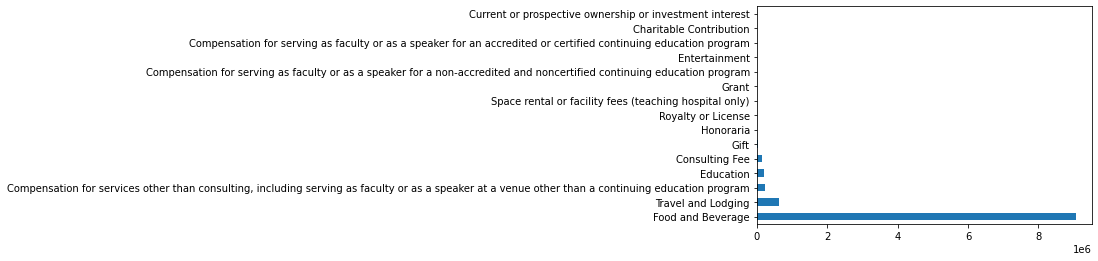

In [12]:
#What are the nature of the general payments? The CMS categorizes open payments with a list of categories defined here:
#https://www.cms.gov/OpenPayments/About/Natures-of-Payment.
cms_gen_data['Nature_of_Payment_or_Transfer_of_Value'].value_counts().plot(kind='barh')

In [13]:
cms_gen_data['Nature_of_Payment_or_Transfer_of_Value'].value_counts()

Food and Beverage                                                                                                                                     9059333
Travel and Lodging                                                                                                                                     616217
Compensation for services other than consulting, including serving as faculty or as a speaker at a venue other than a continuing education program     243245
Education                                                                                                                                              191364
Consulting Fee                                                                                                                                         141341
Gift                                                                                                                                                    42587
Honoraria                                           

It's interesting that most types of expenses fall in the Food and Beverage category, but it makes sense - there are only so many occasions to travel or pay a grant. But this only shows the number of payments, not where the sum of payments are necessarily going.

<AxesSubplot:ylabel='Nature_of_Payment_or_Transfer_of_Value'>

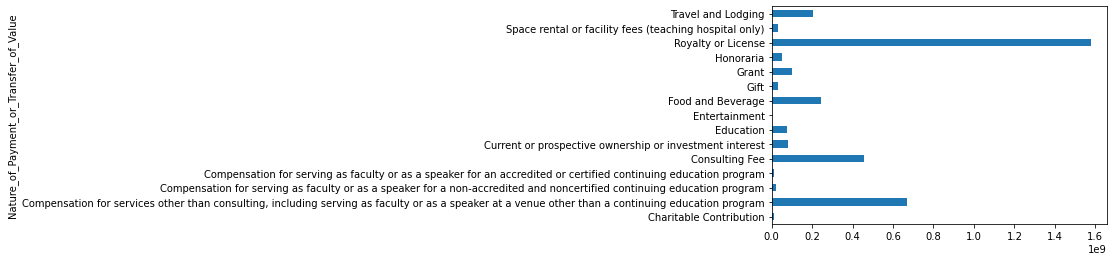

In [14]:
cms_gen_data.groupby('Nature_of_Payment_or_Transfer_of_Value')['Total_Amount_of_Payment_USDollars'].sum().plot(kind='barh')

In the end it looks like food and beverages are just a fraction of total expenditures, whereas royalty and licensing fees demand the largest portion of open payments, followed by compensations for services and consulting fees.

In [15]:
#Who are the recipients of the payments?
cms_gen_data['Covered_Recipient_Type'].value_counts()

Covered Recipient Physician            10319667
Covered Recipient Teaching Hospital       47640
Name: Covered_Recipient_Type, dtype: int64

The above shows that each payment is either to a teaching hospital or a physician. There are no other types of payments in this database, and there are no payments here that are unclassified.

In [16]:
cms_gen_data['Physician_Profile_ID'].value_counts()

57227.0      1249
232968.0     1226
324864.0      980
213579.0      921
354123.0      900
             ... 
321418.0        1
321417.0        1
1138073.0       1
1138076.0       1
4366476.0       1
Name: Physician_Profile_ID, Length: 613924, dtype: int64

In [17]:
# Which countries are involved in this general payments dataset?
cms_gen_data['Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country'].value_counts()

United States                              10281957
Ireland                                       53248
Great Britain (Uk)                             7362
Switzerland                                    7039
Canada                                         3870
Denmark                                        2844
Barbados                                       1862
Germany                                        1664
Japan                                          1452
France                                         1374
Iceland                                        1367
Belgium                                        1203
Sweden                                          659
Israel                                          653
Italy                                           276
New Zealand                                      77
Australia                                        69
Austria                                          50
Korea (Republic of)                              48
Brazil      

In [18]:
cms_gen_data['Recipient_Country'].value_counts()

United States                           10366845
United States Minor Outlying Islands         176
Canada                                        99
Great Britain (Uk)                            48
Mexico                                        32
Germany                                       31
Korea (Republic of)                           12
United Arab Emirates                          12
Russian Federation                             7
Japan                                          7
Italy                                          6
India                                          4
Thailand                                       4
Saudi Arabia                                   3
Lebanon                                        2
Israel                                         2
Guyana                                         2
Dominican Republic                             2
Iran                                           1
Greece                                         1
France              

It may make the most sense to only deal with the USA since that includes more than 99% of the data, and some countries have only a single-digit number of transactions associated with them.

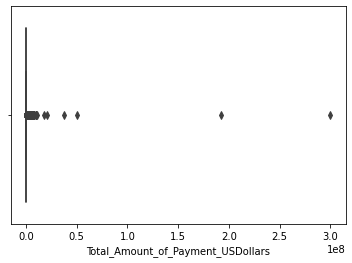

In [66]:
sns.boxplot(x='Total_Amount_of_Payment_USDollars', data=cms_gen_data);

This simple box plot reveals that there are extreme outliers in the data, with the vast, vast majority of payments at a relatively low dollar value.

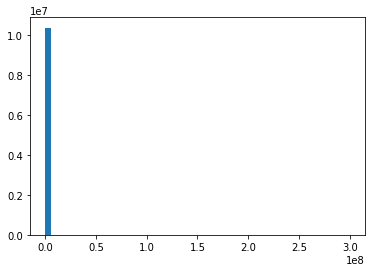

In [45]:
plt.hist(cms_gen_data['Total_Amount_of_Payment_USDollars'],bins=50);

In [64]:
cms_gen_data['Total_Amount_of_Payment_USDollars'].describe()

count    1.036731e+07
mean     3.437341e+02
std      1.140449e+05
min      1.000000e-02
25%      1.230000e+01
50%      1.649000e+01
75%      2.709000e+01
max      3.000000e+08
Name: Total_Amount_of_Payment_USDollars, dtype: float64

In [51]:
cms_gen_data[cms_gen_data['Total_Amount_of_Payment_USDollars']>343.73].count()

Change_Type                                                 620775
Covered_Recipient_Type                                      620775
Teaching_Hospital_CCN                                        29853
Teaching_Hospital_ID                                         29853
Teaching_Hospital_Name                                       29853
                                                             ...  
Product_Category_or_Therapeutic_Area_5                        7042
Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_5      7048
Associated_Drug_or_Biological_NDC_5                           3511
Program_Year                                                620775
Payment_Publication_Date                                    620775
Length: 75, dtype: int64

In [52]:
620775/10367307

0.05987813421556823

Approximately 6% of payments are above the mean payment value of $343.73. Would it make sense to omit these when attempting to predict payments? They would vastly skew any regression model they are a part of.

In [19]:
#Let's examine a big company in particular, to see exactly what they are paying
AZP = cms_gen_data[cms_gen_data['Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name'] == 'AstraZeneca Pharmaceuticals LP']
AZP.head()

,Change_Type,Covered_Recipient_Type,Teaching_Hospital_CCN,Teaching_Hospital_ID,Teaching_Hospital_Name,Physician_Profile_ID,Physician_First_Name,Physician_Middle_Name,Physician_Last_Name,Physician_Name_Suffix,...,Product_Category_or_Therapeutic_Area_4,Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_4,Associated_Drug_or_Biological_NDC_4,Covered_or_Noncovered_Indicator_5,Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_5,Product_Category_or_Therapeutic_Area_5,Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_5,Associated_Drug_or_Biological_NDC_5,Program_Year,Payment_Publication_Date
3186902,NEW,Covered Recipient Physician,NaN,NaN,NaN,78055.0,Burton,G,Shaw,JR.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019,06/30/2020
3186903,NEW,Covered Recipient Physician,NaN,NaN,NaN,85409.0,Raja,G,Devanathan,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019,06/30/2020
3186904,NEW,Covered Recipient Physician,NaN,NaN,NaN,36873.0,Anthony,M,Cotronea,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019,06/30/2020
3186905,NEW,Covered Recipient Physician,NaN,NaN,NaN,1304787.0,Juliet,Gyamfua,Appiah,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019,06/30/2020
3186906,NEW,Covered Recipient Physician,NaN,NaN,NaN,2790146.0,Christopher,NaN,Dingess,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019,06/30/2020


In [20]:
AZP_nature = AZP.groupby('Nature_of_Payment_or_Transfer_of_Value')[['Total_Amount_of_Payment_USDollars','Number_of_Payments_Included_in_Total_Amount']].sum()
AZP_nature

,Total_Amount_of_Payment_USDollars,Number_of_Payments_Included_in_Total_Amount
Nature_of_Payment_or_Transfer_of_Value,,
Charitable Contribution,7.604752e+04,60
"Compensation for services other than consulting, including serving as faculty or as a speaker at a venue other than a continuing education program",2.475140e+07,8841
Consulting Fee,9.709371e+06,2595
Education,1.127989e+05,10591
Food and Beverage,9.101708e+06,548296
Gift,1.000000e+04,1
Grant,5.189673e+05,72
Royalty or License,2.257419e+07,8
Space rental or facility fees (teaching hospital only),7.977722e+05,606


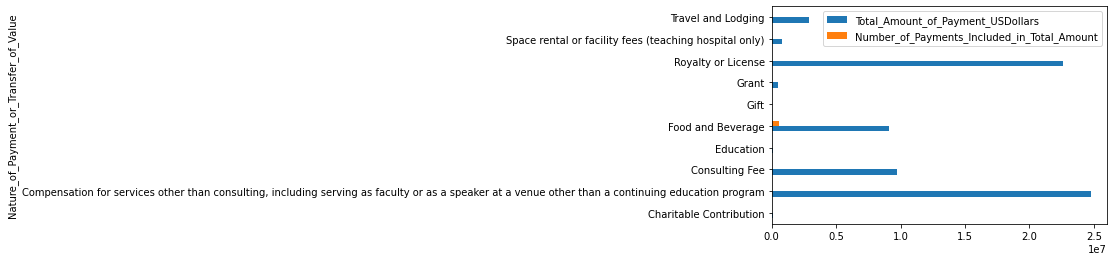

In [21]:
AZP_nature.plot(kind='barh');

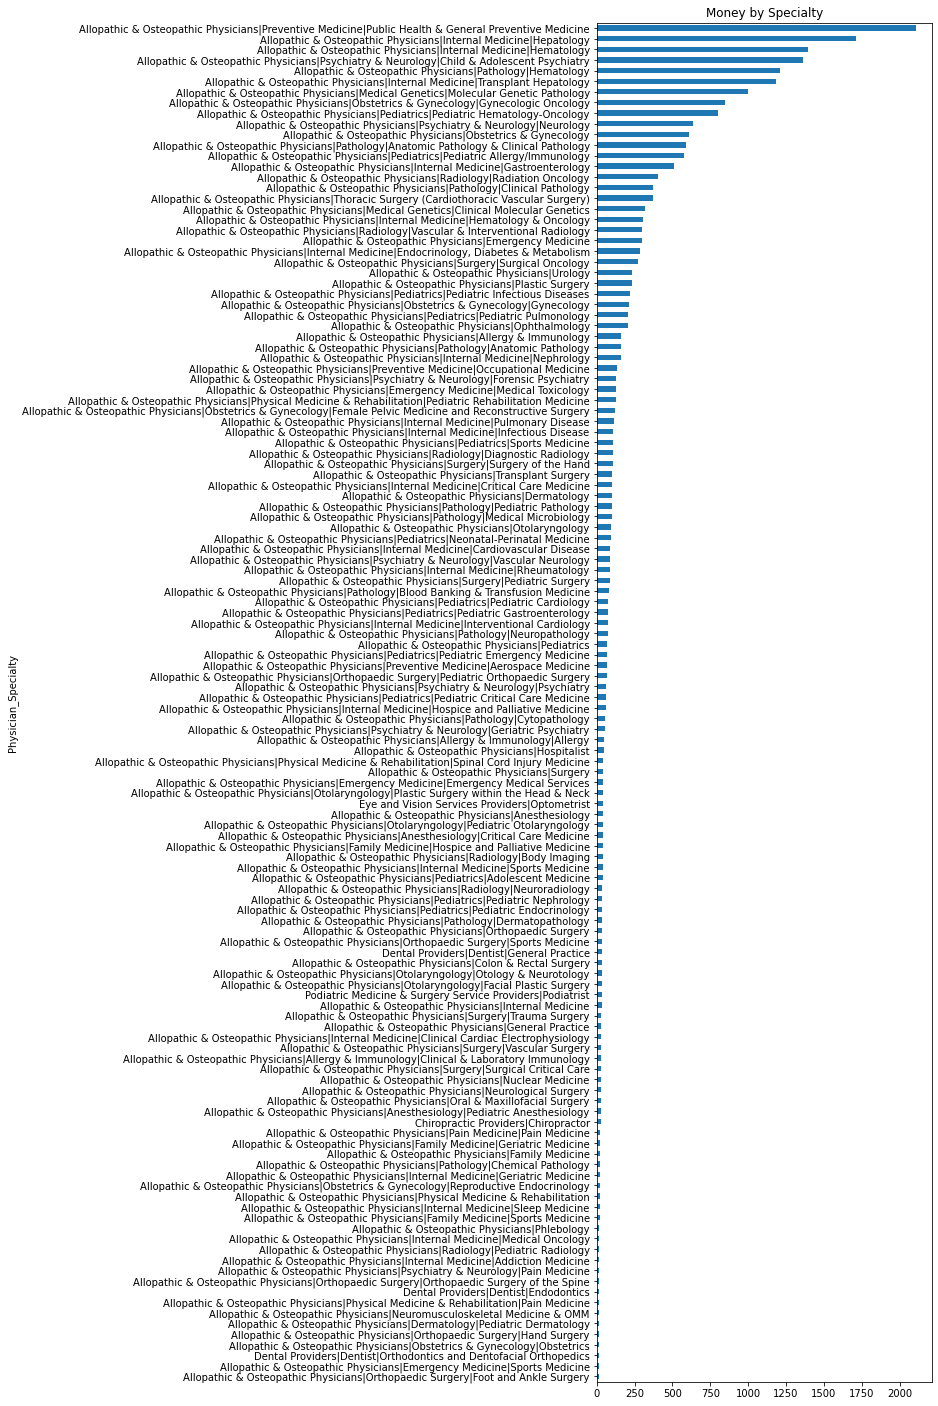

In [22]:
AZP_byspec = AZP.groupby('Physician_Specialty')['Total_Amount_of_Payment_USDollars'].mean()

#Plotting money going to specialties
AZP_byspec.sort_values().plot(kind='barh', figsize=(6, 25), title = 'Money by Specialty');

This sort of gives an idea of which clinical specialties receive most money. It seems that there seem to be "overlaps" in categories - for instance, the specialty "allopathic and osteopathic physicians" shows up over every bar here. There may be ways to categorize these specialties in a more efficient manner. However, these categories will be kept as is in terms of this project because of two reasons. First, perhaps there are contextual reasons that these categories are listed as so, and switching them around would lose some meaning and organization. Secondly, this subset is still part of the larger 2019 general payments dataset, which would contain all these labels and more.

In [23]:
#Are there any records that do not have a transaction price? Those will be dropped, as they are not useful for the analysis
print(cms_gen_data['Total_Amount_of_Payment_USDollars'].isnull().sum())
print(cms_gen_data['Number_of_Payments_Included_in_Total_Amount'].isnull().sum())

0
0


Since no row lacks its payment price data, no rows have to be dropped for missing payment price. Our end goal is to develop a tool that can predict the price of a payment, when its key determining factors are known. However, the determining factors of payment price are not currently established from the data. Some preliminary modeling will help us in that regard.

In terms of model selection, almost all of the features of the data are not numerical, but rather categorical such as type of payment, company name, or country / state of recipient, so the best models will take that into account. Decision Trees and Random Forest models can take categoricals into account, but in sklearn they must be encoded as numericals. This might prove to be too computationally expensive. We'll try simplifying the dataframe a little first (and justify our choices along the way). Null values must also be dealt with.

## Data Wrangling

### Possible columns to delete: 
Any column that deals with information regarding the publishing of a payment as opposed to the nature of the payment itself can be dropped. The column "Change_Type" seems to act sort of like version control for each payment. "Payment Publication Date" also deals with when the payment information was published and doesn't give information regarding the payment itself either. Other columns seem to include: Delay_in_Publication_Indicator, Dispute_Status_for_Publication. record_ID serves as a unique identifier for each individual payment.

"Covered_Recipient_Type" is 100% populated, and classifies whether the payment recipient is a physician or hospital. A closer look at the individual recipients would show that certain physicians and certain hospitals do receive a large percentage of 2019's overall payment total. But perhaps the recipient information can be simplified. For example, instead of using names, only their IDs could be used. With both name information and unique IDs, the identifications are redundant. (Perhaps it may make sense to divide up the data to two different dataframes - one for hospital and one for physician - for human readability of the data.)

In regards to recipient data, we will also assume that the particular street address is irrelevant, but city and / or state may be valuable. However, perhaps this geographical information may be combined to further simplify things. There also exist payments to or from places outside the US, but those payments total to <1% of the monetary total and <1% of the total number of payments, so it may be expedient to just drop those records, which would also imply dropping columns about geographical data on places outside the US (province, country, postal code).

However, address can perhaps be used as a unique identifier for all recipients instead of two columns of IDs, assuming multiple recipients do not share the same address, and the same street address does not occur in multiple states. - Too many assumptions / things to check!?


In [24]:
#Dropping rows where recipients are located outside the US
cms_edit1 = cms_gen_data[cms_gen_data['Recipient_Country']=='United States']

In [25]:
#Dropping least relevant columns
cms_edit1 = cms_edit1.drop(
    ['Change_Type',
     'Teaching_Hospital_CCN',
     'Teaching_Hospital_Name',
     'Physician_First_Name',
     'Physician_Middle_Name',
     'Physician_Last_Name',
     'Physician_Name_Suffix',
     'Recipient_Primary_Business_Street_Address_Line1',
     'Recipient_Primary_Business_Street_Address_Line2',
     'Recipient_Zip_Code',
     'Recipient_Country',
     'Recipient_Province',
     'Recipient_Postal_Code',
     'Record_ID',
     'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name',
     'Contextual_Information',
     'Delay_in_Publication_Indicator',
     'Dispute_Status_for_Publication',
     'Payment_Publication_Date'],axis=1)

cms_edit1.head()

,Covered_Recipient_Type,Teaching_Hospital_ID,Physician_Profile_ID,Recipient_City,Recipient_State,Physician_Primary_Type,Physician_Specialty,Physician_License_State_code1,Physician_License_State_code2,Physician_License_State_code3,...,Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_4,Product_Category_or_Therapeutic_Area_4,Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_4,Associated_Drug_or_Biological_NDC_4,Covered_or_Noncovered_Indicator_5,Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_5,Product_Category_or_Therapeutic_Area_5,Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_5,Associated_Drug_or_Biological_NDC_5,Program_Year
0,Covered Recipient Physician,NaN,827477.0,NORTH LITTLE ROCK,AR,Doctor of Dentistry,Dental Providers|Dentist|Endodontics,AR,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019
1,Covered Recipient Physician,NaN,623090.0,CHAMPAIGN,IL,Doctor of Dentistry,Dental Providers|Dentist|Endodontics,IL,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019
2,Covered Recipient Physician,NaN,3362255.0,BROOKLYN,NY,Doctor of Dentistry,Dental Providers|Dentist,NY,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019
3,Covered Recipient Physician,NaN,3362255.0,BROOKLYN,NY,Doctor of Dentistry,Dental Providers|Dentist,NY,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019
4,Covered Recipient Physician,NaN,3362255.0,BROOKLYN,NY,Doctor of Dentistry,Dental Providers|Dentist,NY,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019


In [26]:
#Reviewing Column types
cms_edit1.dtypes

Covered_Recipient_Type                                                object
Teaching_Hospital_ID                                                 float64
Physician_Profile_ID                                                 float64
Recipient_City                                                        object
Recipient_State                                                       object
Physician_Primary_Type                                                object
Physician_Specialty                                                   object
Physician_License_State_code1                                         object
Physician_License_State_code2                                         object
Physician_License_State_code3                                         object
Physician_License_State_code4                                         object
Physician_License_State_code5                                         object
Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name             object

In [27]:
cms_edit1['Nature_of_Payment_or_Transfer_of_Value'].dtypes

dtype('O')

In [28]:
#Check: if hospital ID and physician ID are unique values
unique_physicians = cms_edit1['Physician_Profile_ID'].nunique()
unique_hospitals = cms_edit1['Teaching_Hospital_ID'].nunique()
print([unique_physicians,unique_hospitals])
print(unique_physicians + unique_hospitals)

[613876, 1172]
615048


In [29]:
#Making a new column "Recipient_ID" that will replace the two columns "Teaching_Hospital_ID" and "Physician_Profile_ID"
cms_edit1['Recipient_ID'] = cms_edit1['Teaching_Hospital_ID'].fillna(cms_edit1['Physician_Profile_ID'])

#Assuming all recipient IDs are unique, this value should equal the sum of the number of unique values of both columns
cms_edit1['Recipient_ID'].nunique()

614233

There are 815 IDs that seem to be shared between physician and hospital ID columns. If that is unintended, then adding a prefix/suffix to the IDs (such as 'h' for hospitals) can easily distinguish them, and solve this issue of non-uniqueness.

In [30]:
#Are there columns that contain both hospital and physician ID?
cms_edit1[(cms_edit1['Teaching_Hospital_ID'].notna()) & (cms_edit1['Physician_Profile_ID'].notna())]

,Covered_Recipient_Type,Teaching_Hospital_ID,Physician_Profile_ID,Recipient_City,Recipient_State,Physician_Primary_Type,Physician_Specialty,Physician_License_State_code1,Physician_License_State_code2,Physician_License_State_code3,...,Product_Category_or_Therapeutic_Area_4,Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_4,Associated_Drug_or_Biological_NDC_4,Covered_or_Noncovered_Indicator_5,Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_5,Product_Category_or_Therapeutic_Area_5,Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_5,Associated_Drug_or_Biological_NDC_5,Program_Year,Recipient_ID


The fact that this filter returns an empty dataframe helps indicate that hospital and physician IDs are separate entities because no row has both a hospital ID and physician ID, and so we will assume that the different types of IDs having overlaps is coincidental.

In [31]:
cms_edit1['Recipient_ID'] = cms_edit1['Recipient_ID'].astype(str)
cms_edit1['Teaching_Hospital_ID'] = cms_edit1['Teaching_Hospital_ID'].astype(str)
cms_edit1['Physician_Profile_ID'] = cms_edit1['Physician_Profile_ID'].astype(str)
cms_edit1['Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID'] = cms_edit1['Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID'].astype(str)

In [32]:
def ID_addendum(col1,col2):
    if col1 == 'Covered Recipient Physician':
        return 'p'+col2
    else:
        return 'h'+col2

cms_edit1['Recipient_ID'] = cms_edit1.apply(lambda x: ID_addendum(x['Covered_Recipient_Type'],x['Recipient_ID']),axis=1)

In [56]:
#After this, we should have 56 / 76 columns
cms_edit2 = cms_edit1
cms_edit2['Recipient_ID'].nunique()

615048

In [ ]:
#After this, we should have 55 / 76 columns
#cms_edit2 = cms_edit2.drop(
#    ['Teaching_Hospital_ID',
#     'Physician_Profile_ID',
#    ],axis=1
#)

In [57]:
#Changing some data types to be more appropriate
change_cols = [
    'Covered_Recipient_Type',
    'Recipient_State',
    'Physician_Primary_Type',
    'Physician_License_State_code1',
    'Physician_License_State_code2',
    'Physician_License_State_code3',
    'Physician_License_State_code4',
    'Physician_License_State_code5',
    'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State',
    'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country',
    'Nature_of_Payment_or_Transfer_of_Value',
    'State_of_Travel',
    'Country_of_Travel',
    'Physician_Ownership_Indicator',
    'Third_Party_Payment_Recipient_Indicator',
    'Charity_Indicator',
    'Third_Party_Equals_Covered_Recipient_Indicator',
    'Related_Product_Indicator'
    ]

cms_edit2[change_cols] = cms_edit2[change_cols].astype('category')

In [58]:
#to Datetime
cms_edit2['Date_of_Payment'] = pd.to_datetime(cms_edit2['Date_of_Payment'])

#And making sure there are no blanks here
cms_edit2['Date_of_Payment'].isnull().sum()

0

Since Datetime will not work in our ML algorithm, instead of using the raw datetime object, several features, namely month, quarter, and weekday, will be extracted from it that can be encoded properly. (Year would also be a useful feature if we were looking at Pfizer's 2019 data in addition to other years.) Examining the 'Date_of_Payment' column shows that none of its values are missing, and it is formatted 'mm/dd/yyyy'. This date column will eventually be dropped before applying ML methods for the sake of space in favor of its features.

Unfortunately, running an extraction of the datetime features on the entire data was taking too long, so it will be done on the subsets of data we will be looking at in closer detail.

In [59]:
cms_edit2.dtypes

Covered_Recipient_Type                                                     category
Teaching_Hospital_ID                                                         object
Physician_Profile_ID                                                         object
Recipient_City                                                               object
Recipient_State                                                            category
Physician_Primary_Type                                                     category
Physician_Specialty                                                          object
Physician_License_State_code1                                              category
Physician_License_State_code2                                              category
Physician_License_State_code3                                              category
Physician_License_State_code4                                              category
Physician_License_State_code5                                              c

In [ ]:
#Adding "new category" for category columns
#for cols in change_cols:
#    cms_edit2[cols] = cms_edit2[cols].cat.add_categories('Blank')

In [ ]:
#Dealing with null values by changing them to the string "Blank"
#def impute_nan(df,col):
#    df[col] = np.where(df[col].isnull(),'Blank',df[col])

#for col in cms_edit2.columns:
#    impute_nan(cms_edit2,col)
    
#cms_edit2.head()

For now we will keep empty values empty. There is still more exploration to be done, and keeping them empty makes things easier.

In [60]:
# Saving Data
datapath = 'D:/Documents/Projects/Capstone1/Data_Edits'

if not os.path.exists(datapath):
    os.mkdir(datapath)

In [61]:
datapath_cleaned = os.path.join(datapath, 'cms_data_cleaned.csv')
if not os.path.exists(datapath_cleaned):
    cms_edit2.to_csv(datapath_cleaned, index=False)

In [62]:
#We will explore one large company in greater depth next
cms_pfizer = cms_edit2[cms_edit2['Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name']=='Pfizer Inc.']

datapath_pfizer = os.path.join(datapath, 'cms_pfizer1.csv')
if not os.path.exists(datapath_pfizer):
    cms_pfizer.to_csv(datapath_pfizer, index=False)

In [63]:
#And here are a few more companies we will consider
#AstraZeneca:
cms_AZP = cms_edit2[cms_edit2['Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name']=='AstraZeneca Pharmaceuticals LP']

datapath_AZP = os.path.join(datapath, 'AZP1.csv')
if not os.path.exists(datapath_AZP):
    cms_AZP.to_csv(datapath_AZP, index=False)
    
# Amgen Inc.:
cms_amg = cms_edit2[cms_edit2['Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name']=='Amgen Inc.']

datapath_amg = os.path.join(datapath, 'Amg1.csv')
if not os.path.exists(datapath_amg):
    cms_amg.to_csv(datapath_amg, index=False)

# Boston Scientific Corporation
cms_BSC = cms_edit2[cms_edit2['Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name']=='Boston Scientific Corporation']

datapath_BSC = os.path.join(datapath, 'BSC1.csv')
if not os.path.exists(datapath_BSC):
    cms_BSC.to_csv(datapath_BSC, index=False)